### 기본설정

#### 크롬드라이버 설치

 <br>
크롬 버전에 맞춰서 웹브라우저를 다운 받아야 합니다.

크롬 버전 확인하는 방법입니다. 
크롬을 열어준후 설정에서 설치된 크롬의 버전의 확인합니다.

![크롬버전 확인하기1](https://github.com/jeong-wooseok/Python/blob/master/refer/img/img_20201227_5.png?raw=true)

![크롬버전 확인하기2](https://github.com/jeong-wooseok/Python/blob/master/refer/img/img_20201227_6.png?raw=true)

[크롬드라이버다운로드 바로가기](https://chromedriver.chromium.org/downloads)
<br>
소수점 앞의 두자리가 동일한 것으로 다운로드 합니다.

![크롬버전 확인하기2](https://github.com/jeong-wooseok/Python/blob/master/refer/img/img_20201227_7.png?raw=true)
현재 파일 경로를 확인하고, 크롬 드라이버를 넣어줍니다.

#### 기타 기본설정

In [4]:
# colab에서 싷행할 경우
# !pip install -U selenium bs4 requests finance-datareader

# 파일 저장 폴더생성
import os
PROJECT_ROOT_DIR = "./fdr_output"
CHAPTER_ID = "stock_check"
SAMPLES_PATH = os.path.join(PROJECT_ROOT_DIR, "samples", CHAPTER_ID)
os.makedirs(SAMPLES_PATH, exist_ok=True)

#파일 경로 생성함수
def mkfile(file): 
    file = os.path.join(SAMPLES_PATH,f'{file}.xlsx')
    return file

sample_o = os.path.join(SAMPLES_PATH,'sample.xlsx')
test = os.path.join(SAMPLES_PATH,'test.xlsx')
sample_modi = os.path.join(SAMPLES_PATH,'sample_modi.xlsx')
sample_modi1 = os.path.join(SAMPLES_PATH,'sample_modi1.xlsx')

# 결측치제거 및 scaling
def scale(df):
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    df = df.fillna(method='pad').dropna(axis=0)
    scaler = MinMaxScaler()
    scaler.fit(df)
    output = scaler.transform(df)
    output = pd.DataFrame(output, columns=df.columns, index=df.index.values)
    return output
    
# 시각화
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 크롤링을 통해 ETF 데이터 가져오기

파이썬의 라이브러리인 셀레니움을 사용하여 크롤링을 진행합니다. 
한국예탁결제원의 증권정보포탈 사이트를 참조합니다. <br> 
(한번 다운로드 받으면 저장되니, 자주 실행하지 마세요)

In [2]:
'''Terminal에서 라이브러리 설치하기:
pip install -U selenium bs4 pandas requests finance-datareader matplotlib '''
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import pandas as pd
import os

try:
    # 홈페이지에 접근하여 ETF 항목 클릭
    driver=webdriver.Chrome("./chromedriver.exe")
    driver.get("http://seibro.or.kr/websquare/control.jsp?w2xPath=/IPORTAL/user/etf/BIP_CNTS06025V.xml&menuNo=174")
    time.sleep(5)
    a=driver.find_element_by_xpath('//*[@id="image10"]')
    a.click()
    path = 'ETF.txt'
    if os.path.exists(path):os.remove(path)

    # 페이지 넘김
    i=1
    while True: 
        time.sleep(1)
        a=driver.find_element_by_xpath('//*[@id="pageList1_page_%d"]'%i)
        a.click()

        time.sleep(2)
        html=driver.page_source
        soup=BeautifulSoup(html,"html.parser")

        f = open("ETF.txt", 'a')
        for anchors in soup.select("#grid1_body_tbody")[0]:
            for anchor in anchors.select("td"):
                data = anchor.get_text()+'\n'
                f.write(data)
        f.close()
        i+=1
# 더이상 읽을 페이지 없을 때, 
except:
     
    print('수집이 끝났습니다')

<ipython-input-2-7c95df6555c4>:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome("./chromedriver.exe")
<ipython-input-2-7c95df6555c4>:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  a=driver.find_element_by_xpath('//*[@id="image10"]')
<ipython-input-2-7c95df6555c4>:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  a=driver.find_element_by_xpath('//*[@id="pageList1_page_%d"]'%i)


수집이 끝났습니다


In [40]:
# df 생성

import pandas as pd
etf = mkfile('etf') 

df = pd.DataFrame()
cols = ['종목명','코드','유형','순자산','종가','거래량','수익율','총보수','운용사']
lines = [1,2,3,4,5,6,9,15,16]
with open('ETF.txt','r') as f:
    data = f.readlines()
    
    for idx in range(len(cols)):
        df[cols[idx]] = [j.replace('\n','') for i, j in enumerate(data) if i % 17 == lines[idx]]
    
# 전처리 : 보수, 수익율 없는 상품 제거
df = df.drop(df[df['총보수']==''].index)
df = df.drop(df[df['수익율']==''].index)

# 전처리 : 계산 가능타입으로 변환
for j in cols[3:6]:
    df[j] = df[j].apply(lambda x: x.replace(',',''))
    df[j] = df[j].astype(int)
for j in cols[6:8]:
    df[j] = df[j].astype(float)

df.to_csv(etf,sep=',',encoding='euc-kr')

print(f'추출한 총 ETF의 수 {len(df)}개')

추출한 총 ETF의 수 508개


In [35]:
df.유형.unique()

array(['시장지수/코스피200', '해외지수/해외지수', '파생상품/인버스', '시장지수/MSCI Korea Index',
       '파생상품/레버리지', '채권/단기자금', '그룹주/삼성', '채권/회사채권', '테마/기타', '테마/우량주',
       '섹터/IT', '섹터/경기소비재', '스타일/스타일', '시장지수/코스닥', '테마/SRI', '섹터/금융',
       '채권/국공채권', '상품/금속', '상품/원유', '섹터/의료', '기타/기타', '통화/미국달러', '섹터/산업재',
       '그룹주/현대차', '테마/녹색성장', '섹터/소재', '그룹주/기타', '시장지수/KRX300', '파생상품/구조화',
       '상품/농산물', '시장지수/코스피100', '투자전략/투자전략', '그룹주/LG', '시장지수/코스피50',
       '시장지수/KRX100', '섹터/필수소비재', '통화/기타통화', '섹터/통신서비스'], dtype=object)

#### ETF : 3개월 수익율 순위

In [36]:
df.sort_values('수익율',ascending =False)[:20]

,종목명,코드,유형,순자산,종가,거래량,수익율,총보수,운용사
131,KODEX 유럽탄소배출권선물ICE(H),400570,해외지수/해외지수,766,12890,305595,33.99,0.64,삼성자산운용
286,SOL 유럽탄소배출권선물S&P(H),400580,해외지수/해외지수,167,12865,45496,33.39,0.55,신한자산운용
280,HANARO 글로벌탄소배출권선물ICE(합성),401590,해외지수/해외지수,180,11985,62404,24.91,0.50,엔에이치아문디자산운용
182,SOL 글로벌탄소배출권선물IHS(합성),400590,해외지수/해외지수,427,12240,82764,24.58,0.55,신한자산운용
175,TIGER Fn반도체TOP10,396500,섹터/IT,474,10170,323131,24.18,0.45,미래에셋자산운용
61,KODEX 반도체,091160,섹터/IT,2475,38845,196469,23.24,0.45,삼성자산운용
90,TIGER 반도체,091230,섹터/IT,1416,39950,85843,23.11,0.46,미래에셋자산운용
230,KBSTAR 비메모리반도체액티브,388420,섹터/IT,264,11185,106798,22.91,0.50,케이비자산운용
185,TIGER 200IT레버리지,243880,파생상품/레버리지,409,60400,10888,22.47,0.69,미래에셋자산운용
388,HANARO Fn K-반도체,395270,섹터/IT,90,10610,29062,22.09,0.45,엔에이치아문디자산운용


#### 종목명, 유형 등 조회

In [22]:
df[df.종목명.str.contains('TIGER 구리')]

,종목명,코드,유형,순자산,종가,거래량,수익율,총보수,운용사
237,TIGER 구리실물,160580,상품/금속,257,10770,15483,0.23,0.83,미래에셋자산운용


### 파생상품 제외한 목록 만들기 (연금계좌 활용)

#### 연금용 ETF : 3개월 수익율 순위

In [41]:
a = '파생상품'
df1 = df[~df['유형'].str.contains(a)]
# print(df['유형'].unique())
# print()
# print(df1['유형'].unique())

# etf_연금 = mkfile('etf_연금') 
# df1.to_csv(etf_연금,sep=',',encoding='euc-kr')
df1.sort_values('수익율',ascending =False)[:20]

,종목명,코드,유형,순자산,종가,거래량,수익율,총보수,운용사
131,KODEX 유럽탄소배출권선물ICE(H),400570,해외지수/해외지수,766,12890,305595,33.99,0.64,삼성자산운용
286,SOL 유럽탄소배출권선물S&P(H),400580,해외지수/해외지수,167,12865,45496,33.39,0.55,신한자산운용
280,HANARO 글로벌탄소배출권선물ICE(합성),401590,해외지수/해외지수,180,11985,62404,24.91,0.50,엔에이치아문디자산운용
182,SOL 글로벌탄소배출권선물IHS(합성),400590,해외지수/해외지수,427,12240,82764,24.58,0.55,신한자산운용
175,TIGER Fn반도체TOP10,396500,섹터/IT,474,10170,323131,24.18,0.45,미래에셋자산운용
61,KODEX 반도체,091160,섹터/IT,2475,38845,196469,23.24,0.45,삼성자산운용
90,TIGER 반도체,091230,섹터/IT,1416,39950,85843,23.11,0.46,미래에셋자산운용
230,KBSTAR 비메모리반도체액티브,388420,섹터/IT,264,11185,106798,22.91,0.50,케이비자산운용
388,HANARO Fn K-반도체,395270,섹터/IT,90,10610,29062,22.09,0.45,엔에이치아문디자산운용
165,KODEX 미국반도체MV,390390,해외지수/해외지수,534,12250,85427,20.04,0.45,삼성자산운용


### 금일 ETF 수익율 순위 확인

In [42]:
import requests
import json
from pandas import json_normalize
url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df2 = json_normalize(json_data['result']['etfItemList'])
df2.sort_values('changeRate',ascending=False)[:10]
df2.columns = ['코드','TabCode','종목명','현재가','등/락','가격변동','일수익율','일평균가','3개월수익율','거래량/일','거래금액/일,백만','marketSum']
df2 = df2.fillna(0)
df2['3개월수익율'] = df2['3개월수익율'].round(1)

df = pd.merge(df,df2[['코드','가격변동','일수익율','거래금액/일,백만']], on ='코드') # 기존 df에 필수정보 포함
df1 = pd.merge(df1,df2[['코드','가격변동','일수익율','거래금액/일,백만']], on ='코드') # 기존 df1(연금 용 목록)에 필수정보 포함

a = '파생상품'
li =df1[~df1['유형'].str.contains(a)]
li.sort_values('일수익율',ascending=False)[:20]
# df.to_excel('etf_list.xlsx',header=True,index=False

,종목명,코드,유형,순자산,종가,거래량,수익율,총보수,운용사,가격변동,일수익율,"거래금액/일,백만"
191,TIGER 차이나반도체FACTSET,396520,해외지수/해외지수,283,8830,59799,-1.18,0.49,미래에셋자산운용,110,1.26,73
135,TIGER 차이나클린에너지SOLACTIVE,396510,해외지수/해외지수,595,9675,99007,-7.46,0.49,미래에셋자산운용,105,1.10,207
358,ARIRANG 선진국MSCI(합성 H),195970,해외지수/해외지수,72,12420,12367,3.11,0.50,한화자산운용,135,1.10,86
123,KODEX K-미래차액티브,385520,테마/기타,695,11485,58821,4.36,0.50,삼성자산운용,110,0.97,565
383,KINDEX 필리핀MSCI(합성),261920,해외지수/해외지수,59,14750,451,-0.10,0.50,한국투자신탁운용,135,0.92,1
197,KBSTAR 비메모리반도체액티브,388420,섹터/IT,264,11185,106798,22.91,0.50,케이비자산운용,95,0.86,872
145,KODEX 차이나심천ChiNext(합성),256750,해외지수/해외지수,539,14125,24804,-2.59,0.47,삼성자산운용,115,0.82,132
252,KODEX S&P글로벌인프라(합성),269420,해외지수/해외지수,151,13030,10719,3.99,0.26,삼성자산운용,105,0.81,74
1,TIGER 차이나전기차SOLACTIVE,371460,해외지수/해외지수,32541,16500,6069883,-5.23,0.49,미래에셋자산운용,130,0.79,49020
357,TIGER 일본엔선물,292560,통화/기타통화,72,10250,3652,-0.97,0.25,미래에셋자산운용,75,0.74,89


In [43]:
def price_plot(codes,period):
    from datetime import datetime,timedelta
    import FinanceDataReader as fdr
    for code in codes:
        df = pd.read_csv(etf, encoding = 'euckr', index_col=0)
        df['코드'] = df['코드'].astype(str)
        temp = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
        df.loc[temp,'코드'] = '0'+ df.loc[temp,'코드'].astype(str)
        e_date = datetime.now()
        s_date = e_date - timedelta(int(period))
        df_temp = fdr.DataReader(code, s_date ,e_date)
        name = df[df.코드 == code].종목명.values[0]
        df_kospi = fdr.DataReader('KS11', s_date ,e_date)
        df_temp['p_index'] = df_temp['Close'].apply(lambda x: x/df_temp.iloc[0,3])
        df_temp['p_index'].plot(legend = 'a',label= name, figsize=(16,8))
    df_kospi['p_index'] = df_kospi['Close'].apply(lambda x: x/df_kospi.iloc[0,3])
    df_kospi['p_index'].plot(color = 'grey',legend = 'a',label= 'KOSPI지수', figsize=(16,8))
        
# 다중 차트 만드는 함수  
def price_plot_s(codes,period,row,col, fig = (16,8)):
    import pandas as pd
    from datetime import datetime,timedelta
    import FinanceDataReader as fdr
    import matplotlib.pyplot as plt
    for idx, code in enumerate(codes):
        df = pd.read_csv(etf, encoding = 'euckr', index_col=0)
        df['코드'] = df['코드'].astype(str)
        temp = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
        df.loc[temp,'코드'] = '0'+ df.loc[temp,'코드'].astype(str)
        e_date = datetime.now()
        s_date = e_date - timedelta(int(period))
        df_temp = fdr.DataReader(code, s_date ,e_date)
        df_kospi = fdr.DataReader('KS11', s_date ,e_date)
        name = df[df.코드 == code].종목명.values[0]
                
        plt.subplot(row,col,idx+1) # subplot : 도화지를 나눔, 1행/2열로 나누고 첫번째도화지에...
        df_temp['p_index'] = df_temp['Close'].apply(lambda x: x/df_temp.iloc[0,3])
        df_temp['p_index'].plot(legend = 'a',label= name, figsize=fig)
        df_kospi['p_index'] = df_kospi['Close'].apply(lambda x: x/df_kospi.iloc[0,3])
        df_kospi['p_index'].plot(color = 'grey', legend = 'a',label= 'KOSPI지수', figsize=fig)

# 코드 리스트로 df 불러오기
def price_codes(codes, period):
    import pandas as pd
    import FinanceDataReader as fdr
    from datetime import datetime,timedelta
    import matplotlib.pyplot as plt
    df = pd.read_csv(etf, encoding = 'euckr', index_col=0)
    df['코드'] = df['코드'].astype(str)
    temp = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
    df.loc[temp,'코드'] = '0'+ df.loc[temp,'코드'].astype(str)

    e_date = datetime.now()
    s_date = e_date - timedelta(int(period))
    
    df_m = pd.DataFrame()
    df_m_index = pd.DataFrame()
    
    for code in codes:
        df_temp = fdr.DataReader(code, s_date ,e_date)
        name = df[df.코드 == code].종목명.values[0]
        df_temp['p_index'] = df_temp['Close'].apply(lambda x: x/df_temp.iloc[0,3])
        df_m[name] = df_temp['Close']
        df_m_index[name] = df_temp['p_index']
    df_kospi = fdr.DataReader('KS11', s_date ,e_date)
    df_cur = fdr.DataReader('USD/KRW', s_date ,e_date)
    df_kospi['p_index'] = df_kospi['Close'].apply(lambda x: x/df_kospi.iloc[0,3])
    df_cur['p_index'] = df_cur['Close'].apply(lambda x: x/df_cur.iloc[0,3])
    df_m_index['KOSPI'] = df_kospi['p_index'] 
    df_m_index['USD/KRW'] = df_cur['p_index'] 
    
    return df_m, df_m_index  
        
# 특정텍스트 포함 조건식을 걸어서 가격 df를 만드는 함수
def price_texts(유형,종목명, period):
    import pandas as pd
    import FinanceDataReader as fdr
    from datetime import datetime,timedelta
    import matplotlib.pyplot as plt
    df = pd.read_csv(etf, encoding = 'euckr', index_col=0)
    df['코드'] = df['코드'].astype(str)
    temp = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
    df.loc[temp,'코드'] = '0'+ df.loc[temp,'코드'].astype(str)
    
    if 유형 != 'None':
        codes = [code for code in df[df.유형.str.contains(유형)].코드]
        names = [n for n in df[df.유형.str.contains(유형)].종목명]
    elif 종목명 != 'None':
        codes = [code for code in df[df.종목명.str.contains(종목명)].코드]
        names = [n for n in df[df.종목명.str.contains(종목명)].종목명]
    print(f'해당종목은 {names}입니다.')
    e_date = datetime.now()
    s_date = e_date - timedelta(int(period))
    
    df_m = pd.DataFrame()
    df_m_index = pd.DataFrame()
    for code in codes:
        df_temp = fdr.DataReader(code, s_date ,e_date)
        name = df[df.코드 == code].종목명.values[0]
        df_temp['p_index'] = df_temp['Close'].apply(lambda x: x/df_temp.iloc[0,3])
        df_m[name] = df_temp['Close']
        df_m_index[name] = df_temp['p_index']
        
    df_kospi = fdr.DataReader('KS11', s_date ,e_date)
    df_cur = fdr.DataReader('USD/KRW', s_date ,e_date)
    df_kospi['p_index'] = df_kospi['Close'].apply(lambda x: x/df_kospi.iloc[0,3])
    df_cur['p_index'] = df_cur['Close'].apply(lambda x: x/df_cur.iloc[0,3])
    df_m_index['KOSPI'] = df_kospi['p_index'] 
    df_m_index['USD/KRW'] = df_cur['p_index'] 

    return df_m, df_m_index

# 구성종목 확인함수
def comp(codes):
    import requests
    import FinanceDataReader as fdr
    import pandas as pd
    df = pd.read_csv(etf, encoding = 'euckr', index_col=0)
    df['코드'] = df['코드'].astype(str)
    temp = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
    df.loc[temp,'코드'] = '0'+ df.loc[temp,'코드'].astype(str)
    
    df_l = []
    try:
        for idx, code in enumerate(codes):
            name = df[df.코드 == code].종목명.values[0]
            url = f'https://finance.naver.com/item/main.nhn?code={code}'
            html = requests.get(url).text
            dfs = pd.read_html(html)
            dfs_c = dfs[3]
            if len(dfs_c)>10 :
                if dfs_c['구성비중'][2]!='-':
                    dfs_c = dfs_c.dropna()[['구성종목(구성자산)','구성비중','등락률']]
                    dfs_c.columns = [name,f'구성비중{idx+1}',f'등락률{idx+1}']
                    df_l.append(dfs_c)
        df_m = pd.concat(df_l,axis=1)
    except:
        pass    
        df_m = pd.concat(df_l,axis=1)
    return df_m

In [48]:
li

,종목명,코드,유형,순자산,종가,거래량,수익율,총보수,운용사,가격변동,일수익율,"거래금액/일,백만"
0,KODEX 200,069500,시장지수/코스피200,56769,39105,4900691,0.43,0.15,삼성자산운용,-615,-1.55,116877
1,TIGER 차이나전기차SOLACTIVE,371460,해외지수/해외지수,32541,16500,6069883,-5.23,0.49,미래에셋자산운용,130,0.79,49020
2,KODEX MSCI Korea TR,278540,시장지수/MSCI Korea Index,22112,12615,1851061,1.61,0.15,삼성자산운용,-205,-1.60,10113
3,TIGER 200,102110,시장지수/코스피200,21089,39155,974114,0.53,0.05,미래에셋자산운용,-615,-1.55,38218
4,TIGER 미국나스닥100,133690,해외지수/해외지수,18344,82605,197323,4.68,0.07,미래에셋자산운용,-2060,-2.43,25792
...,...,...,...,...,...,...,...,...,...,...,...,...
428,KBSTAR 200철강소재,285020,섹터/소재,20,9125,3419,-4.20,0.19,케이비자산운용,-175,-1.88,12
429,KBSTAR 200에너지화학,284990,섹터/소재,18,12865,1110,-11.00,0.19,케이비자산운용,-295,-2.24,8
430,KBSTAR 200생활소비재,287330,섹터/필수소비재,17,7230,1953,-11.94,0.19,케이비자산운용,-90,-1.23,0
431,KBSTAR 200경기소비재,287310,섹터/경기소비재,15,10765,582,-5.57,0.19,케이비자산운용,-145,-1.33,4


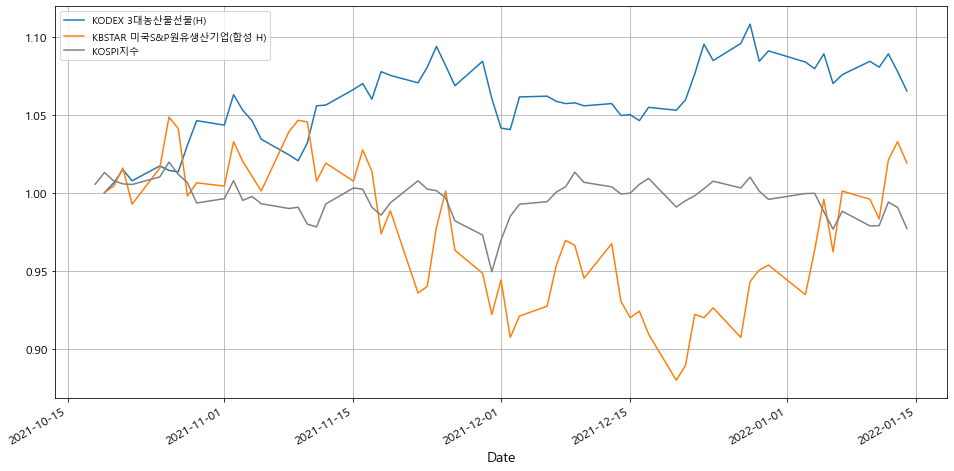

In [15]:
codes =['271060','219390']
price_plot(codes,90)

#### 금일 상위 20개 종목 30일 차트 조회

In [47]:
li_code = [code for code in li.코드]
price_plot_s(li,30,5,4,(32,16)) # (리스트, 일자,행,열,차트크기)

ValueError: Symbol('종목명') not found

#### 관심종목 30일 차트 조회

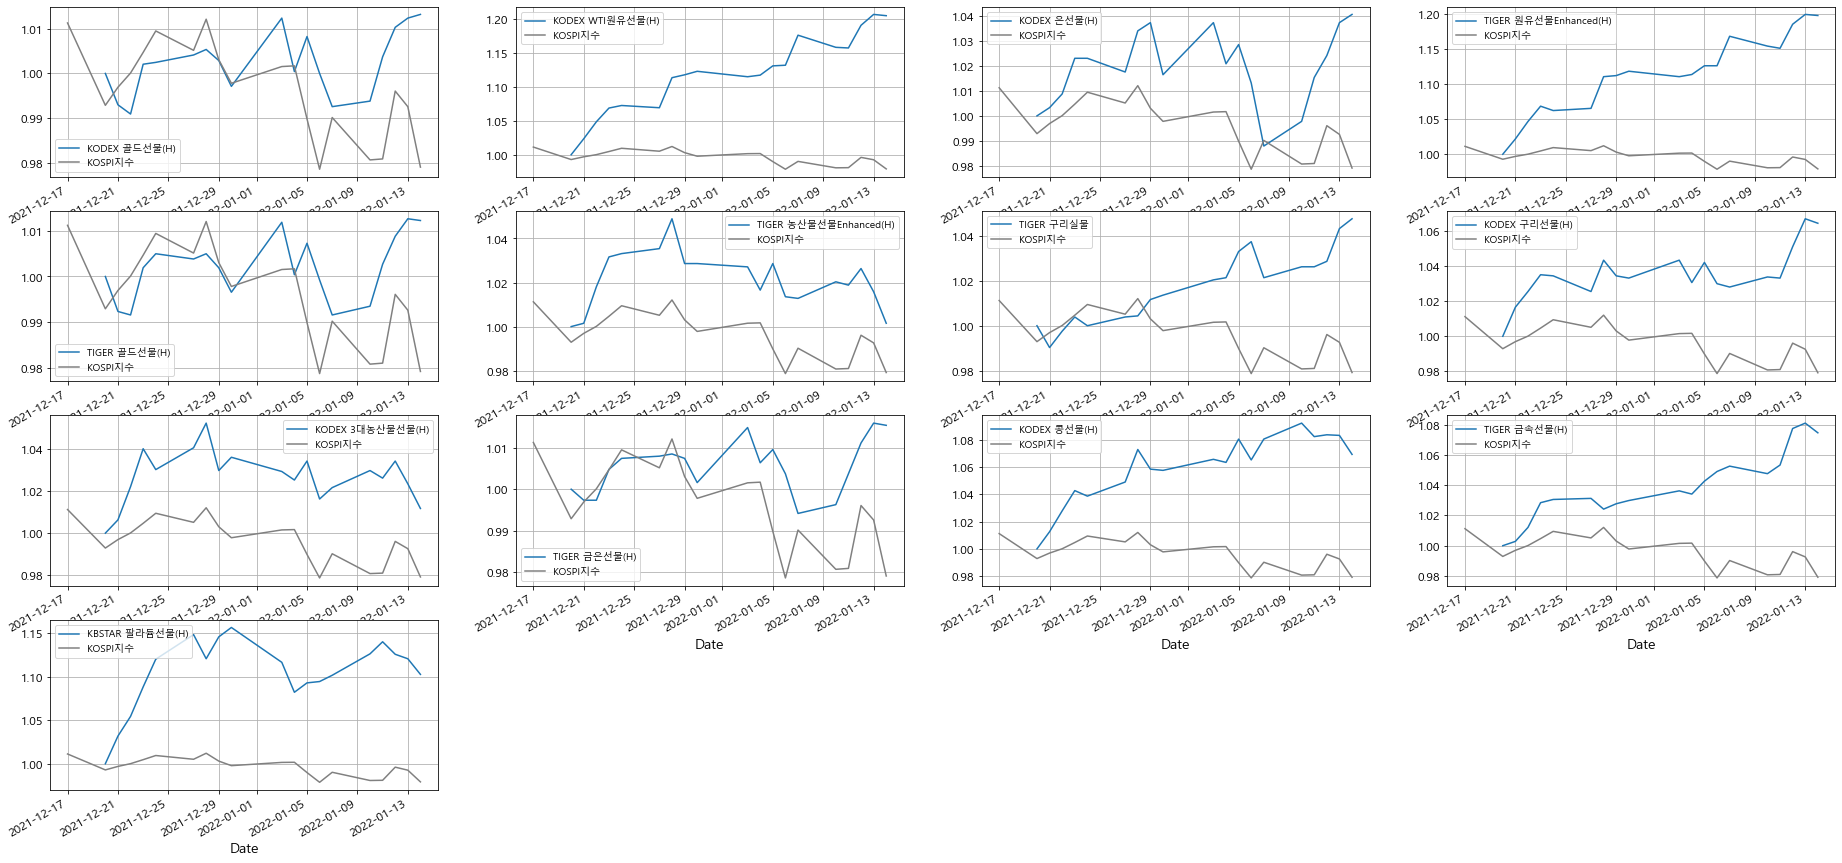

In [17]:
li = [code for code in df1[df1.유형.str.contains('상품')].코드]
price_plot_s(li,30,4,4,(32,16))

#### 관심 종목 corr구하기 (kospi 비교)

In [16]:
# li = [code for code in df1[df1.유형.str.contains('상품')].코드]
df = price_codes(li,365)[1]
df.corr()

,KODEX 3대농산물선물(H),KBSTAR 미국S&P원유생산기업(합성 H),TIGER 농산물선물Enhanced(H),KODEX 콩선물(H),TIGER 화장품,TIGER 베타플러스,TIGER 원유선물Enhanced(H),TIGER 200에너지화학레버리지,KODEX WTI원유선물(H),KODEX 미국S&P에너지(합성),...,KODEX 은행,ARIRANG 200동일가중,TIGER 200 금융,KBSTAR 200에너지화학,TIGER 금속선물(H),TIGER 미디어컨텐츠,TIGER 200IT레버리지,TIGER MSCI KOREA ESG리더스,KOSPI,USD/KRW
KODEX 3대농산물선물(H),1.000000,0.245535,0.993708,0.938901,0.267841,0.776525,0.290313,0.729694,0.213894,-0.042422,...,0.719772,0.691854,0.756436,0.672013,0.779763,0.507425,0.817959,0.692643,0.726044,-0.854116
KBSTAR 미국S&P원유생산기업(합성 H),0.245535,1.000000,0.307663,0.087534,0.279831,0.201701,0.866020,0.149447,0.767499,0.931436,...,0.710752,0.270441,0.665920,0.109022,0.215459,0.433696,0.326194,0.247635,0.262445,-0.158100
TIGER 농산물선물Enhanced(H),0.993708,0.307663,1.000000,0.926539,0.300445,0.784736,0.359073,0.738905,0.274060,0.018550,...,0.767293,0.709229,0.799857,0.682575,0.797866,0.544393,0.825980,0.708496,0.741530,-0.862896
KODEX 콩선물(H),0.938901,0.087534,0.926539,1.000000,0.432884,0.906940,0.050179,0.875036,-0.070761,-0.228920,...,0.664614,0.829484,0.722620,0.841573,0.876789,0.580064,0.889169,0.838508,0.860400,-0.930117
TIGER 화장품,0.267841,0.279831,0.300445,0.432884,1.000000,0.713184,0.073489,0.708690,-0.172839,0.057241,...,0.556111,0.830716,0.619023,0.769127,0.674204,0.858770,0.577470,0.778379,0.775365,-0.579461
TIGER 베타플러스,0.776525,0.201701,0.784736,0.906940,0.713184,1.000000,0.065167,0.982390,-0.133533,-0.118979,...,0.732584,0.974130,0.793486,0.976059,0.942984,0.764939,0.949326,0.985450,0.991886,-0.922624
TIGER 원유선물Enhanced(H),0.290313,0.866020,0.359073,0.050179,0.073489,0.065167,1.000000,0.024175,0.962816,0.827089,...,0.604305,0.103021,0.557777,-0.026495,0.180521,0.339295,0.201932,0.082630,0.109823,-0.107043
TIGER 200에너지화학레버리지,0.729694,0.149447,0.738905,0.875036,0.708690,0.982390,0.024175,1.000000,-0.172686,-0.161076,...,0.668314,0.956865,0.737974,0.989258,0.924989,0.750817,0.933922,0.980663,0.977272,-0.874826
KODEX WTI원유선물(H),0.213894,0.767499,0.274060,-0.070761,-0.172839,-0.133533,0.962816,-0.172686,1.000000,0.792964,...,0.445423,-0.121496,0.387305,-0.238287,-0.009299,0.115237,0.031476,-0.136751,-0.105343,0.046618
KODEX 미국S&P에너지(합성),-0.042422,0.931436,0.018550,-0.228920,0.057241,-0.118979,0.827089,-0.161076,0.792964,1.000000,...,0.466949,-0.040709,0.400126,-0.201143,-0.114742,0.183604,0.035837,-0.060097,-0.050345,0.172044


In [198]:
df = price_texts('None','골드',20)[1]
df.corr()

해당종목은 ['KODEX 골드선물(H)', 'KINDEX 골드선물 레버리지(합성 H)', 'TIGER 골드선물(H)', 'KODEX 골드선물인버스(H)']입니다.


,KODEX 골드선물(H),KINDEX 골드선물 레버리지(합성 H),TIGER 골드선물(H),KODEX 골드선물인버스(H),KOSPI,USD/KRW
KODEX 골드선물(H),1.000000,0.997207,0.995138,-0.995663,-0.091680,-0.719158
KINDEX 골드선물 레버리지(합성 H),0.997207,1.000000,0.991869,-0.991374,-0.110353,-0.726562
TIGER 골드선물(H),0.995138,0.991869,1.000000,-0.991177,-0.082051,-0.723606
KODEX 골드선물인버스(H),-0.995663,-0.991374,-0.991177,1.000000,0.085097,0.712533
KOSPI,-0.091680,-0.110353,-0.082051,0.085097,1.000000,0.105469
USD/KRW,-0.719158,-0.726562,-0.723606,0.712533,0.105469,1.000000


In [ ]:
li = [code for code in df1[df1.유형.str.contains('상품')].코드]
df = price_codes(li,365)[1]
df.corr()

In [195]:
li = [code for code in df2.code[:20]]
df_t = price_codes(li,30)
df_t[1].tail(5)

,KODEX 200,TIGER 200,KODEX 단기채권,TIGER MSCI Korea TR,KODEX 200선물인버스2X,KODEX MSCI Korea TR,KODEX 삼성그룹,KODEX 레버리지,KODEX 200TR,KODEX 종합채권(AA-이상)액티브,KBSTAR 200,KODEX 코스닥150 레버리지,KODEX 인버스,KODEX 단기채권PLUS,ARIRANG 200,TIGER 단기통안채,KINDEX 200,KOSEF 200,HANARO 200,TIGER 미국나스닥100
Date,,,,,,,,,,,,,,,,,,,,
2021-01-06,1.098975,1.098045,1.000390,1.093915,0.822300,1.093854,1.114458,1.204087,1.104114,0.998003,1.099407,1.067348,0.906593,1.000583,1.098941,1.00035,1.098724,1.099690,1.098087,1.015955
2021-01-07,1.124595,1.123129,1.000536,1.116402,0.782230,1.116694,1.139650,1.262740,1.125105,0.998638,1.125135,1.080753,0.885714,1.000632,1.124413,1.00035,1.125991,1.125286,1.124899,1.021971
2021-01-08,1.174353,1.173432,1.000536,1.172288,0.710801,1.173588,1.190033,1.377885,1.176742,0.998275,1.175647,1.093840,0.846154,1.000681,1.175627,1.00040,1.175688,1.175401,1.173808,1.045293
2021-01-11,1.177319,1.176129,1.000585,1.178902,0.709059,1.183140,1.192771,1.386058,1.178421,0.999682,1.178206,1.097670,0.843956,1.000632,1.177236,1.00045,1.179987,1.179577,1.176233,1.056665
2021-01-12,1.156149,1.155765,1.000634,1.160053,0.735192,1.155731,1.168675,1.331490,1.156591,0.998911,1.156519,1.079796,0.860440,1.000632,1.155919,1.00040,1.157690,1.157483,1.155888,1.049166


#### 구성종목 확인하기

In [113]:
comp(['228810','228800'])

,TIGER 미디어컨텐츠,구성비중1,등락률1,TIGER 여행레저,구성비중2,등락률2
1,CJ CGV,11.62%,+7.65%,파라다이스,9.91%,+2.95%
2,스튜디오드래곤,11.38%,+4.33%,강원랜드,9.66%,+5.06%
3,CJ ENM,10.87%,+5.69%,호텔신라,9.47%,+3.91%
4,JYP Ent.,9.52%,+1.93%,하나투어,9.20%,+3.86%
5,제이콘텐트리,9.20%,+6.96%,한진칼,8.71%,+0.59%
9,에스엠,8.28%,-0.17%,GKL,8.20%,+2.21%
10,와이지엔터테인먼트,8.25%,+2.84%,아난티,8.10%,-1.10%
11,초록뱀,6.25%,+3.61%,롯데관광개발,7.93%,+1.01%
12,키이스트,4.29%,0.00%,모두투어,5.28%,+5.32%
13,지니뮤직,3.48%,+0.68%,진에어,4.35%,-0.62%


In [21]:
li = [code for code in df1[df1.종목명.str.contains('미디어')].코드]
comp(li)

,TIGER 미디어컨텐츠,구성비중1,등락률1,KODEX 미디어&엔터테인먼트,구성비중2,등락률2
1,CJ CGV,12.04%,+0.53%,카카오,23.89%,-0.66%
2,스튜디오드래곤,11.43%,-0.10%,엔씨소프트,18.18%,-1.37%
3,CJ ENM,11.05%,-0.53%,NAVER,17.85%,+3.29%
4,제이콘텐트리,9.47%,-2.46%,넷마블,14.65%,+1.60%
5,JYP Ent.,9.34%,+0.54%,펄어비스,2.99%,+0.04%
9,와이지엔터테인먼트,8.16%,+3.87%,제일기획,2.59%,+3.64%
10,에스엠,7.95%,+5.53%,컴투스,2.59%,+2.34%
11,초록뱀,6.23%,+2.24%,스튜디오드래곤,2.21%,-0.10%
12,키이스트,4.13%,+1.40%,카카오게임즈,1.99%,+1.30%
13,위지윅스튜디오,3.51%,+1.82%,JYP Ent.,1.79%,+0.54%


In [114]:
comp([code for code in df1[df1.유형.str.contains('우량주')].코드])

,TIGER TOP10,구성비중1,등락률1,KODEX KTOP30,구성비중2,등락률2,TIGER KTOP30,구성비중3,등락률3,TIGER 우량가치,...,등락률4,KOSEF 블루칩,구성비중5,등락률5,KODEX FnKorea50,구성비중6,등락률6,KBSTAR 우량업종,구성비중7,등락률7
1,삼성전자,25.58%,-0.44%,삼성전자,23.07%,-0.44%,삼성전자,23.08%,-0.44%,한화생명,...,-4.19%,SK이노베이션,3.46%,-3.23%,SK이노베이션,2.74%,-3.23%,LG전자,2.98%,-2.46%
2,SK하이닉스,15.59%,-3.01%,LG화학,10.10%,-3.61%,LG화학,10.14%,-3.61%,현대차,...,-2.43%,LG전자,3.10%,-2.46%,LG전자,2.64%,-2.46%,현대모비스,2.90%,-5.82%
3,LG화학,9.84%,-3.61%,NAVER,7.83%,-1.62%,NAVER,7.85%,-1.62%,CJ,...,-0.20%,현대모비스,3.03%,-5.82%,현대차,2.47%,-2.43%,현대차,2.81%,-2.43%
4,NAVER,8.59%,-1.62%,삼성SDI,7.39%,+2.05%,삼성SDI,7.42%,+2.05%,이마트,...,+5.48%,현대차,2.97%,-2.43%,LG,2.41%,-0.97%,LG,2.72%,-0.97%
5,셀트리온,8.48%,+2.67%,카카오,4.59%,+0.99%,카카오,4.60%,+0.99%,효성중공업,...,-2.36%,LG,2.84%,-0.97%,삼성SDI,2.33%,+2.05%,삼성SDI,2.63%,+2.05%
9,현대차,8.19%,-2.43%,유한양행,3.90%,-0.95%,셀트리온,3.80%,+2.67%,현대제철,...,-2.52%,삼성SDI,2.75%,+2.05%,삼성전자,2.21%,-0.44%,삼성전자,2.50%,-0.44%
10,삼성SDI,8.04%,+2.05%,셀트리온,3.86%,+2.67%,유한양행,3.72%,-0.95%,기아차,...,+0.14%,삼성전자,2.64%,-0.44%,LG화학,2.19%,-3.61%,한화솔루션,2.46%,-5.46%
11,카카오,5.98%,+0.99%,현대모비스,3.57%,-5.82%,현대모비스,3.58%,-5.82%,SK렌터카,...,+2.97%,한국전력,2.54%,-0.57%,카카오,2.15%,+0.99%,LG화학,2.43%,-3.61%
12,현대모비스,4.88%,-5.82%,SK이노베이션,2.98%,-3.23%,SK이노베이션,2.99%,-3.23%,효성화학,...,+0.85%,LG디스플레이,2.53%,+2.04%,삼성물산,2.13%,-3.32%,두산퓨얼셀,2.43%,-4.70%
13,엔씨소프트,3.88%,-3.17%,롯데케미칼,2.91%,+8.87%,롯데케미칼,2.92%,+8.87%,현대그린푸드,...,+1.91%,삼성물산,2.51%,-3.32%,SK,2.12%,-2.93%,삼성물산,2.41%,-3.32%


In [25]:
comp([code for code in df2.sort_values('일수익율',ascending=False)[:20].code])

,TIGER 화장품,구성비중5,등락률5,TIGER 베타플러스,구성비중6,등락률6,마이티 코스피100,구성비중11,등락률11,TIGER 은행,...,등락률15,KBSTAR 200에너지화학,구성비중16,등락률16,TIGER 미디어컨텐츠,구성비중18,등락률18,TIGER MSCI KOREA ESG리더스,구성비중20,등락률20
1,아모레G,11.86%,+3.61%,삼성전자,25.88%,-1.21%,삼성전자,33.17%,-1.21%,하나금융지주,...,+2.27%,LG화학,20.22%,+3.74%,CJ CGV,12.04%,+0.53%,SK하이닉스,16.53%,+2.33%
2,아모레퍼시픽,11.85%,+4.19%,SK하이닉스,14.29%,+2.33%,SK하이닉스,6.29%,+2.33%,KB금융,...,+3.17%,SK이노베이션,20.01%,-1.23%,스튜디오드래곤,11.43%,-0.10%,LG화학,10.23%,+3.74%
3,한국콜마,10.83%,+1.37%,삼성SDI,7.88%,+0.67%,LG화학,3.82%,+3.74%,신한지주,...,+2.68%,SK,13.16%,+4.97%,CJ ENM,11.05%,-0.53%,삼성SDI,9.59%,+0.67%
4,LG생활건강,10.45%,+2.12%,현대차,7.56%,-0.96%,셀트리온,3.51%,-0.39%,우리금융지주,...,+1.33%,한화솔루션,7.34%,+2.23%,제이콘텐트리,9.47%,-2.46%,NAVER,8.76%,+3.29%
5,코스맥스,7.96%,+2.78%,현대모비스,4.35%,+1.96%,NAVER,3.35%,+3.29%,기업은행,...,+1.36%,롯데케미칼,6.81%,-1.12%,JYP Ent.,9.34%,+0.54%,KB금융,4.28%,+2.27%
9,콜마비앤에이치,7.62%,+0.60%,기아차,3.62%,+2.85%,삼성SDI,3.29%,+0.67%,BNK금융지주,...,+3.91%,S-Oil,4.25%,+4.26%,와이지엔터테인먼트,8.16%,+3.87%,SK이노베이션,3.74%,-1.23%
10,한국콜마홀딩스,7.02%,+2.10%,KB금융,3.04%,+2.27%,현대차,3.19%,-0.96%,DGB금융지주,...,-0.50%,금호석유,3.84%,+1.25%,에스엠,7.95%,+5.53%,엔씨소프트,3.71%,-1.37%
11,현대바이오랜드,6.69%,0.00%,삼성물산,2.89%,+0.69%,카카오,2.47%,-0.66%,JB금융지주,...,+1.05%,SK케미칼,3.65%,+0.42%,초록뱀,6.23%,+2.24%,LG생활건강,3.49%,+2.12%
12,네오팜,3.99%,+6.08%,신한지주,2.88%,+3.17%,현대모비스,1.87%,+1.96%,NaN,...,-0.57%,SKC,2.70%,-1.19%,키이스트,4.13%,+1.40%,LG전자,3.45%,+1.08%
13,코리아나,3.19%,+3.02%,하나금융지주,2.15%,+2.68%,POSCO,1.66%,+1.99%,NaN,...,+2.30%,OCI,2.61%,+4.37%,위지윅스튜디오,3.51%,+1.82%,신한지주,3.41%,+3.17%


In [ ]:
# 추출 및 수집 : 최초원본 
# from selenium import webdriver
# from bs4 import BeautifulSoup
# import time
# import pandas as pd
# import os

# PROJECT_ROOT_DIR = "./fdr_output"
# CHAPTER_ID = "stock_check"
# SAMPLES_PATH = os.path.join(PROJECT_ROOT_DIR, "samples", CHAPTER_ID)
# os.makedirs(SAMPLES_PATH, exist_ok=True)

# def mkfile(file): #파일 경로 생성함수
#     file = os.path.join(SAMPLES_PATH,f'{file}.csv')
#     return file

# etf = mkfile('etf') 

# try:
#     # 홈페이지에 접근하여 ETF 항목 클릭
#     driver=webdriver.Chrome("./chromedriver.exe")
#     driver.get("http://seibro.or.kr/websquare/control.jsp?w2xPath=/IPORTAL/user/etf/BIP_CNTS06025V.xml&menuNo=174")
#     time.sleep(5)
#     a=driver.find_element_by_xpath('//*[@id="image10"]')
#     a.click()
#     path = 'ETF.txt'
#     if os.path.exists(path):os.remove(path)

#     # 페이지 넘김
#     i=1

#     while True: 
#         time.sleep(1)
#         a=driver.find_element_by_xpath('//*[@id="pageList1_page_%d"]'%i)
#         a.click()

#         time.sleep(2)
#         html=driver.page_source
#         soup=BeautifulSoup(html,"html.parser")

#         f = open("ETF.txt", 'a')
#         for anchors in soup.select("#grid1_body_tbody")[0]:
#             for anchor in anchors.select("td"):
#                 data = anchor.get_text()+'\n'
#                 f.write(data)
#         f.close()
#         i+=1
    
    
# # 더이상 읽을 테이지 없을 때, 
# except:
#     # 리스트화 하여 항목을 담아주고, 딕셔너리로 변환하여, 판다스 DF만들기
#     df = pd.DataFrame()
#     cols = ['종목명','코드','유형','순자산','종가','거래량','수익율','총보수','운용사']
#     종목명 = [] #1;
#     코드 = [] #2
#     유형 = [] #3
#     순자산 =[] #4
#     종가 =[] #5
#     거래량 = [] #6
#     수익율 = [] #9
#     총보수 = [] #15
#     운용사 = [] #16
#     with open('ETF.txt','r') as f:
#         data = f.readlines()
#         for i, j in enumerate(data):
#             if i % 17 == 1:종목명.append(j.replace('\n',''))
#             elif i % 17 ==2:코드.append(j.replace('\n',''))
#             elif i % 17 ==3:유형.append(j.replace('\n',''))
#             elif i % 17 ==4:순자산.append(j.replace('\n',''))
#             elif i % 17 ==5:종가.append(j.replace('\n',''))
#             elif i % 17 ==6:거래량.append(j.replace('\n',''))
#             elif i % 17 ==9:수익율.append(j.replace('\n',''))
#             elif i % 17 ==15:총보수.append(j.replace('\n',''))
#             elif i % 17 ==16:운용사.append(j.replace('\n',''))      
#     data = {'종목명':종목명,'코드':코드,'유형':유형,'순자산':순자산,'종가':종가,'거래량':거래량,'수익율':수익율,'총보수':총보수,'운용사':운용사}
#     df = pd.DataFrame(data, columns = cols)

#     # 보수, 수익율 없는 상품 제거하기
#     df = df.drop(df[df['총보수']==''].index)
#     df = df.drop(df[df['수익율']==''].index)

#     # 전처리 : 계산 가능한 값으로 변환하기
#     df['거래량']=df['거래량'].apply(lambda x: x.replace(',',''))
#     df['종가']=df['종가'].apply(lambda x: x.replace(',',''))
#     df['순자산']=df['순자산'].apply(lambda x: x.replace(',',''))
#     df['거래량']=df['거래량'].astype(int)
#     df['종가']=df['종가'].astype(int)
#     df['순자산']=df['순자산'].astype(int)
#     df['수익율']=df['수익율'].astype(float)
#     df['총보수']=df['총보수'].astype(float)

#     # 전처리 : 5개 자리인 코드를 6개자리로 변환
#     df['코드'] = df['코드'].astype(str)
#     code = [i for i in df[df['코드'].apply(lambda x: len(x))<=5].index]
#     df.loc[code,'코드'] = '0'+ df.loc[code,'코드'].astype(str)

#     df.to_csv(etf,sep=',',encoding='euc-kr')
    
#     print('연산이 끝났습니다')
#     print(f'추출한 총 ETF의 수 {len(df)}개')